# Create a pretty figure with latex.<br>


In [1]:
# @title ##### Installing stuff... (it may take a few seconds)

%%capture
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

import numpy as np
from matplotlib import pyplot

In [44]:
import pandas as pd
exper = pd.read_csv("https://raw.githubusercontent.com/emartineznunez/latex/master/exp.csv")
m3c_ts = pd.read_csv("https://raw.githubusercontent.com/emartineznunez/latex/master/M3C_TS.csv")
m3c = pd.read_csv("https://raw.githubusercontent.com/emartineznunez/latex/master/M3C.csv")

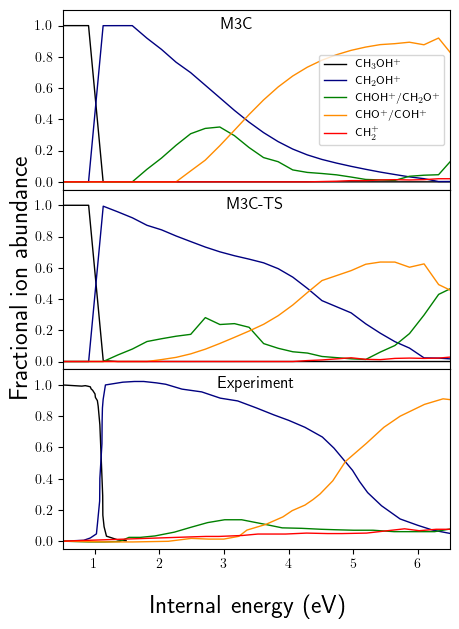

In [55]:
# @title ##### Figure
from scipy.interpolate import make_interp_spline, BSpline

px = exper['parent_x'] - 10.5
py = exper['parent_y']

ch2ohx = exper['ch2oh_x'] - 10.5
ch2ohy = exper['ch2oh_y']

chohx = exper['choh_x'] - 10.5
chohy = exper['choh_y']

chox = exper['cho_x'] - 10.5
choy = exper['cho_y']

ch2x = exper['ch2_x'] - 10.5
ch2y = exper['ch2_y']

x_m3cts = m3c_ts['X'] - 0.45
x_m3c = m3c['X']

parent_m3cts = m3c_ts['parent']
ch2oh_m3cts = m3c_ts['ch2oh']
ch2o_m3cts = m3c_ts['ch2o']
hco_m3cts = m3c_ts['hco']
ch2_m3cts = m3c_ts['ch2']

#Average of 5 values
for k,ele in enumerate(parent_m3cts):
  if k > 10 and k < 28:
    for i in [-2,-1,1,2]:
      ch2oh_m3cts[k] +=  ch2oh_m3cts[k+i]
      hco_m3cts[k] +=  hco_m3cts[k+i]
    ch2oh_m3cts[k] = ch2oh_m3cts[k] / 5
    hco_m3cts[k] = hco_m3cts[k] / 5

parent_m3c = m3c['parent']
ch2oh_m3c = m3c['ch2oh']
ch2o_m3c = m3c['ch2o']
hco_m3c = m3c['hco']
ch2_m3c = m3c['ch2']

#Average of 5 values
for k,ele in enumerate(parent_m3cts):
  if k > 10 and k < 28:
    for i in [-2,-1,1,2]:
      ch2oh_m3c[k] +=  ch2oh_m3c[k+i]
      hco_m3c[k] +=  hco_m3c[k+i]
    ch2oh_m3c[k] = ch2oh_m3c[k] / 5
    hco_m3c[k] = hco_m3c[k] / 5

pyplot.rcParams['text.usetex'] = True
pyplot.rcParams['figure.figsize'] = (5,7)

fig = pyplot.figure()
gs = fig.add_gridspec(3, 1, hspace=0, wspace=0)
(ax1), (ax2) ,(ax3) = gs.subplots(sharex='col', sharey='row')

ax1.plot(x_m3c,parent_m3c,'-',color='black',label='CH$_3$OH$^+$',mfc='none',linewidth=1.0)
ax1.plot(x_m3c,ch2oh_m3c,'-',color='navy',label='CH$_2$OH$^+$',mfc='none',linewidth=1.0)
ax1.plot(x_m3c,ch2o_m3c,'-',color='green',label='CHOH$^+$/CH$_2$O$^+$',mfc='none',linewidth=1.0)
ax1.plot(x_m3c,hco_m3c,'-',color='darkorange',label='CHO$^+$/COH$^+$',mfc='none',linewidth=1.0)
ax1.plot(x_m3c,ch2_m3c,'-',color='red',label='CH$_2^+$',mfc='none',linewidth=1.0)

ax2.plot(x_m3cts,parent_m3cts,'-',color='black',label='CH$_3$OH$^+$',mfc='none',linewidth=1.0)
ax2.plot(x_m3cts,ch2oh_m3cts,'-',color='navy',label='CH$_2$OH$^+$',mfc='none',linewidth=1.0)
ax2.plot(x_m3cts,ch2o_m3cts,'-',color='green',label='CHOH$^+$/CH$_2$O$^+$',mfc='none',linewidth=1.0)
ax2.plot(x_m3cts,hco_m3cts,'-',color='darkorange',label='CHO$^+$/COH$^+$',mfc='none',linewidth=1.0)
ax2.plot(x_m3cts,ch2_m3cts,'-',color='red',label='CH$_2^+$',mfc='none',linewidth=1.0)

ax3.plot(px,py,'-',color='black',label='CH$_3$OH$^+$',mfc='none',linewidth=1.0)
ax3.plot(ch2ohx,ch2ohy,'-',color='navy',label='CH$_2$OH$^+$',mfc='none',linewidth=1.0)
ax3.plot(chohx,chohy,'-',color='green',label='CHOH$^+$/CH$_2$O$^+$',mfc='none',linewidth=1.0)
ax3.plot(chox,choy,'-',color='darkorange',label='CHO$^+$/COH$^+$',mfc='none',linewidth=1.0)
ax3.plot(ch2x,ch2y,'-',color='red',label='CH$_2^+$',mfc='none',linewidth=1.0)

ax1.set_xlim(0.5,6.5)
ax1.set_ylim(-0.05,1.1)
ax2.set_xlim(0.5,6.5)
ax2.set_ylim(-0.05,1.1)
ax3.set_xlim(0.5,6.5)
ax3.set_ylim(-0.05,1.1)

#ax1.legend(fontsize=6,loc="upper right")
ax1.legend(fontsize=8)
ax1.set_title('M3C',x=0.45, y=0.9,pad=-1)
ax2.set_title('M3C-TS',y=0.9,pad=-1)
ax3.set_title('Experiment',y=0.9,pad=-1)

for ax in fig.get_axes():
    ax.label_outer()

fig.supylabel('Fractional ion abundance',fontsize=18)
fig.supxlabel('Internal energy (eV)',fontsize=18)
pyplot.savefig('comp2.svg')
pyplot.show()